# **CycleGAN**

1. Implemeting the Loss Funtion (Least Square Loss) of a CycleGAN model
2. Observing two Generators and two Discriminators

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
import numpy as np
from PIL import Image

torch.manual_seed(0)
plt.rcParams["figure.figsize"] = (10, 10)

from tqdm.auto import tqdm

import glob
import random
import os
import sys


/home/tonyox/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        '''
        Args:
            root - root dir where the image data is stored
            transform - for transformation or albumentations
            mode - to specify train or test
            
        
        '''
        """For the Men and Female Class, and then Horse / Zebra class"""
        # Two categories for image translation from Domain A to Domain B
        # self.files_A = sorted(glob.glob(os.path.join(root, 'men') + '/*.*')) # constructs a dir path for Domain A
        # self.files_B = sorted(glob.glob(os.path.join(root, 'women') + '/*.*')) # for Domain B
        
        """Horse Zebra"""
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        
        self.new_perm()
        assert len(self.files_A) > 0, "ERROR!!.. Freak Baby !!"
    
    def new_perm(self):
        # random permutation for ensuring equal sampling 
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]
    
    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        
        if item_A.shape[0] != 3:
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3:
            item_B = item_B.repeat(3, 1, 1)
        
        if index == len(self) - 1:
            self.new_perm()
        
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))
    

## Generator

CycleGAN generator is the same as U-Net generator or Pix2Pix with additional residual block connections between the encoding and decoding blocks

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        '''No change in dimension'''
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        # we dont need to add AdaIN as we did in StyleGAN 
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        
        return original_x + x # Residual connections

```Upsampling and Downsampling blocks```

In [4]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        '''Encoder of the U-Net architecture'''
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size, padding=1,
                               stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        
        if use_bn: # batch normalization
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn
        # use instance norm if only BN
    
    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module): # upsample
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        '''Decoder of the U-Net architecture'''
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3,
                                        stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x        

### Feature Map

In [5]:
class FeatureMapBlock(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, 
                              padding=3, padding_mode='reflect')

    def forward(self, x):
        x = self.conv(x)
        return x

#### Genenerator

In [6]:
'''CycleGAN Generator'''

class Generator(nn.Module):
    '''
    Feature Map
    2 Downsampling blocks
    9 Residual blocks
    2 Upsampling blocks
    Feature Map 
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        # feature map
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        # Downsampling the latent space
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        
        # Upsampling the feature learnt from the downsampling
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        
        # expand
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        # feature map 
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
        # Activation [-1, 1]
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        
        xn = self.downfeature(x13)
        return self.tanh(xn)

## PatchGAN Discriminator

In [7]:
'''The discriminator of the CycleGAN is discriminator of the PatchGAN '''
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=64):
        super().__init__()
        
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        # In disc, we use Leaky Relu, and we dont use batch norm as we are just dicriminating it
        
        '''Downsampling the Image obtained from the Generator'''
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1) # getting single output 
    
    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn        

### To view the samples

In [8]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2 # [-1, 1] to [0, 1]
    image_shifted = image_tensor
    # detach from the computation graph, move to cpu. Then, reshape to 4D tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Configurations

Should make in seperate Py file

In [9]:
adv_criterion = nn.MSELoss() # for Adversarial loss
recon_criterion = nn.L1Loss() # for cycle consistence / Re construction loss

n_epochs = 20
dim_A = 3
dim_B = 3
display_step = 15
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# check for GPU name
if device == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)  
    print(f'Using GPU: {gpu_name}')
else:
    print('Using CPU for computation')
    
'''CUDA out of memory issue'''
# Then, use device = 'cpu'

device = 'cpu'

Using CPU for computation


### Preparations

In [10]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

"""First, do the sanity check"""
"""Result:
Worked for the Horse Zebra
Took Long for the Celeb Dataset as high res
"""

sanity_check = '/home/jerlshin/Documents/My_Work/Generative Adversarial Networks Specialization/C3 Apply GAN - 26 hrs/Sanity_Check'
root_dir = '/home/jerlshin/Documents/My_Work/__DATASET__/Men and Women Classification/'
H_Z_root = './CycleGAN/Files/tf/horse2zebra/'

dataset = ImageDataset(root=H_Z_root, transform=transform)

AssertionError: ERROR!!.. Freak Baby !!

In [ ]:
dataset[0][0].shape, dataset[0][1].shape, len(dataset[0])

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]), 2)

<Figure size 1200x600 with 0 Axes>

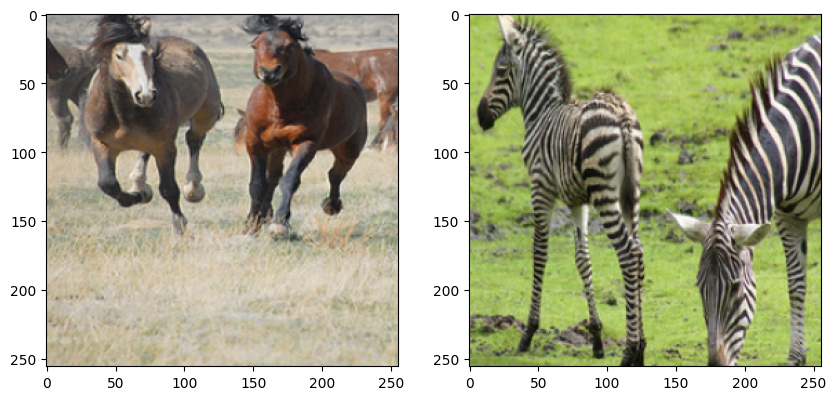

In [ ]:
def show_image(dataset, index):
    image1 = dataset[index][0]
    image2 = dataset[index][1]
    
    image1 = (image1 + 1) / 2
    image2 = (image2 + 1) / 2

    image1, image2 = image1.detach().cpu(), image2.detach().cpu()
    plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(image1.permute(1, 2, 0).squeeze())
    ax[1].imshow(image2.permute(1, 2, 0).squeeze())

show_image(dataset, 3)

In [ ]:
device # Kaggle should be changed for device

'cpu'

### Initialization 

In [ ]:
# Generator from domain A to B and vice versa
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)

# optimizer for Generator -=> Merge the parameters
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))

# Discriminaotr for Domain A
disc_A = Discriminator(dim_A).to(device)
# Optimizer for Discriminator for Domain A
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))

# Disc for Domain B
disc_B = Discriminator(dim_B).to(device)
# opt for Disc for Domain B
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))


# Initializing the weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d): # bias for only batch norm / instance norm
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

#### Loading and Init the weights

In [ ]:
'''If need Pretrained weights, Use Hugging Face for Men Female'''

gen_AB = gen_AB.apply(weights_init)
gen_BA = gen_BA.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)


Loaded Pretrained weights


### ```Discriminator Loss```

In [ ]:
def get_disc_loss(real_x, fake_x, disc_x, adv_criterion):
    '''
    Calculates the loss of the disc 
    ''' # disc_x - disc for class x. Takes images and returns real/fake class x prediction matrices
    disc_fake_X_hat = disc_x(fake_x.detach()) # detach generator
    # for fake images
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
    
    disc_real_X_hat = disc_x(real_x)
    # for real iamges
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
    
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2
    
    return disc_loss

### ```Generator Loss```

Some changes from Pix2Pix generator loss.

--> **```Least Square Loss```**

In [ ]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    # Generating fake Y with Gen
    fake_y = gen_XY(real_X)
    # Disc output of matrix
    disc_fake_Y_hat = disc_Y(fake_y)
    '''The generated should look same like the real one''' # So, we use target as 1
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
    return adversarial_loss, fake_y

### ```Identity Loss```


Maybe need for come, and in paper, first they used this, and then after on later implementation excluded this 

In [ ]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X) # opposite generator 
    identity_loss = identity_criterion(identity_X, real_X)
    return identity_loss, identity_X

### Cycle Consistency

In [ ]:
def get_cycle_consistency_loss(real_x, fake_Y, gen_YX, cycle_criterion):
    # Shoulf look like real when generated backwards
    cycle_X = gen_YX(fake_Y)
    # loss funtions
    cycle_loss = cycle_criterion(cycle_X, real_x)
    return cycle_loss, cycle_X

## Generator LOSS

In [ ]:
def get_gen_loss(real_A, real_B, 
                 gen_AB, gen_BA,
                 disc_A, disc_B,
                 adv_criterion, identity_criterion, cycle_criterion, 
                 lambda_identity=0.1, lambda_cycle=10):
    
    # Adversarial Loss 
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB
    
    # Identity Loss 
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B
    
    # Cycle-consistency Loss 
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB
    
    # Total loss
    # lambda for how much we should care about each loss
    gen_loss = lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss + gen_adversarial_loss
    return gen_loss, fake_A, fake_B

## CycleGAN **Training**

In [ ]:
def show_graph(steps, generator_losses, discriminator_losses):# Update live graphs
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    # Generator and Discriminator Loss Graph
    plt.plot(steps, generator_losses, label='Generator Loss', color='blue')
    plt.plot(steps, discriminator_losses, label='Discriminator Loss', color='red')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.draw()
    plt.pause(0.001)

In [ ]:
'''Mixed Precision Training
Storeed some model param in lower precision (float16) while storing others in higher precision (float32) 
'''

# Sample
n_epochs = 50
device = 'cpu'
# Emabling interactive mode
plt.ion()

def train(save_model=True):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    generator_losses = []
    discriminator_losses = []
    steps = []
    
    # scaler = GradScaler()
    '''In case of memory issues, we use mixed Precision Training, else we dont use that
    In cases, it results in Loss of precision, Gradient underflow'''
    for epoch in range(n_epochs):
        for real_A, real_B in tqdm(dataloader):
            # image_width = image.shape[3]
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad() 
            with torch.no_grad():
                fake_A = gen_BA(real_B)
                
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) 
            disc_A_opt.step() 

            ### Update discriminator B ###
            disc_B_opt.zero_grad()
            with torch.no_grad():
                fake_B = gen_AB(real_A)
                
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) 
            disc_B_opt.step() 

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() 
            gen_opt.step() 

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                
                
                generator_losses.append(mean_generator_loss)
                discriminator_losses.append(mean_discriminator_loss)
                steps.append(cur_step)
                
                '''For graph visualization'''
                # show_graph(steps, generator_losses, discriminator_losses)
            
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"Samples/cycleGAN_{cur_step}.pth")
                    
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                
            cur_step += 1

os.makedirs(os.path.join(os.getcwd(), 'Samples'), exist_ok=True)
train()

In [ ]:
device = 'cpu'

In [ ]:
torch.cuda.is_available()

True

#### **MODEL IS TRAINED IN CLOUD**

In [ ]:
checkpoint_path_1 = "cycleGAN_9800.pth"
checkpoint = torch.load(checkpoint_path_1, map_location=torch.device(device=device))

gen_AB.load_state_dict(checkpoint['gen_AB'])
gen_BA.load_state_dict(checkpoint['gen_BA'])

gen_AB.eval()
gen_BA.eval()

Generator(
  (upfeature): FeatureMapBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
  )
  (contract1): ContractingBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (activation): ReLU()
    (instancenorm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (contract2): ContractingBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (activation): ReLU()
    (instancenorm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (res0): ResidualBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (instancenorm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, tra

# **TEST**

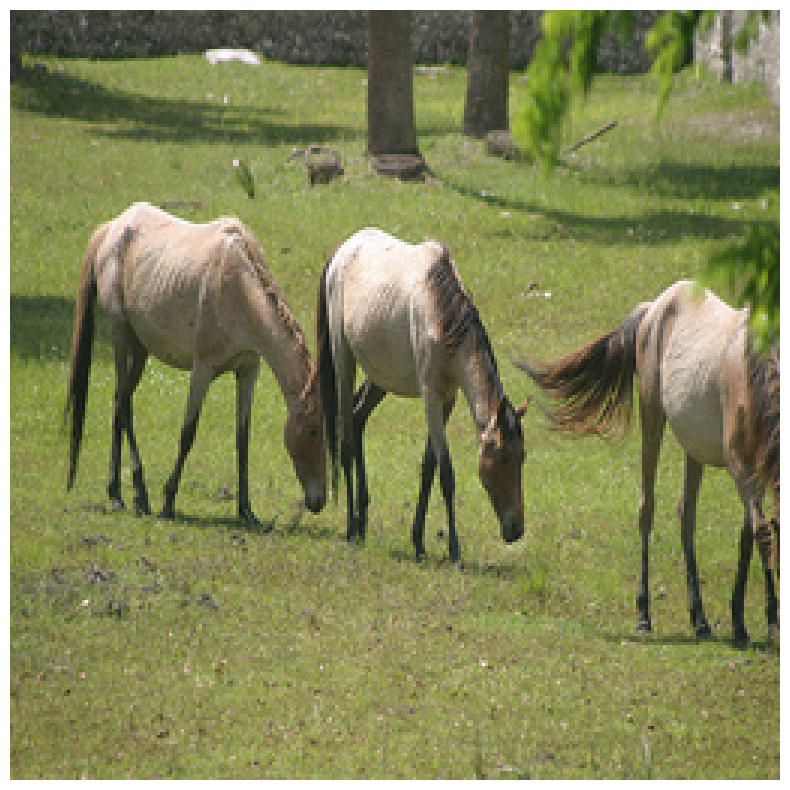

In [ ]:
image1 = 'test_img_1.jpg'
image2 = 'test_img_2.jpg'
img1, img2 = mpimg.imread(image1), mpimg.imread(image2)
plt.imshow(img1)
plt.axis('off')
plt.show()

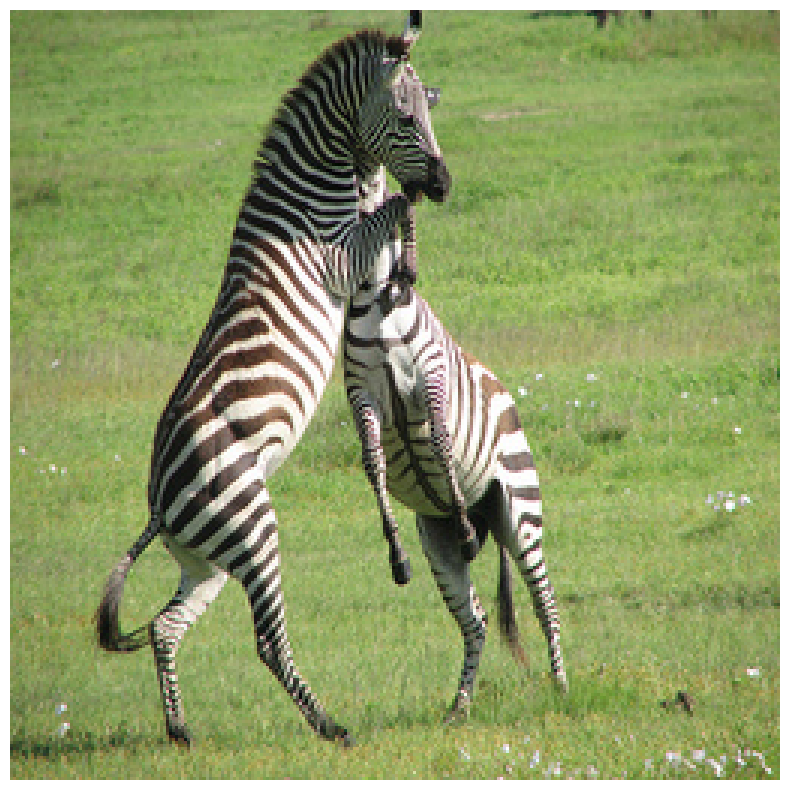

In [ ]:
plt.imshow(img2)
plt.axis('off')
plt.show()

In [ ]:
device

'cpu'

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.ToTensor(),
])

image1 = transform(Image.open(image1))
image1 = image1.to(device)

image2 = transform(Image.open(image2))
image2 = image2.to(device)

with torch.no_grad():
    trans_B = gen_AB(image1)
    trans_A = gen_BA(image2)
    
trans_B, trans_B.shape

(tensor([[[-0.1995, -0.2136, -0.2108,  ...,  0.0224,  0.2288,  0.2532],
          [-0.1458, -0.2188, -0.2040,  ...,  0.0521,  0.2260,  0.2894],
          [-0.2623, -0.3660, -0.2902,  ...,  0.0523,  0.2242,  0.2928],
          ...,
          [-0.1050, -0.0717, -0.1204,  ..., -0.1521, -0.0531, -0.0035],
          [ 0.0335,  0.0696, -0.1210,  ..., -0.1637, -0.0969, -0.0421],
          [ 0.0732,  0.1059,  0.0245,  ..., -0.1757, -0.1509, -0.0486]],
 
         [[-0.1361, -0.1355, -0.1158,  ...,  0.0733,  0.2675,  0.2840],
          [-0.0527, -0.1309, -0.1005,  ...,  0.0888,  0.2600,  0.3185],
          [-0.1840, -0.2888, -0.2354,  ...,  0.0760,  0.2499,  0.3171],
          ...,
          [-0.1121, -0.0671, -0.1002,  ..., -0.1663, -0.0586, -0.0306],
          [ 0.0368,  0.1034, -0.0797,  ..., -0.1686, -0.1219, -0.0910],
          [ 0.1189,  0.1550,  0.0720,  ..., -0.1617, -0.1659, -0.0769]],
 
         [[-0.5487, -0.5656, -0.5597,  ..., -0.1477,  0.0340,  0.0251],
          [-0.5161, -0.5796,

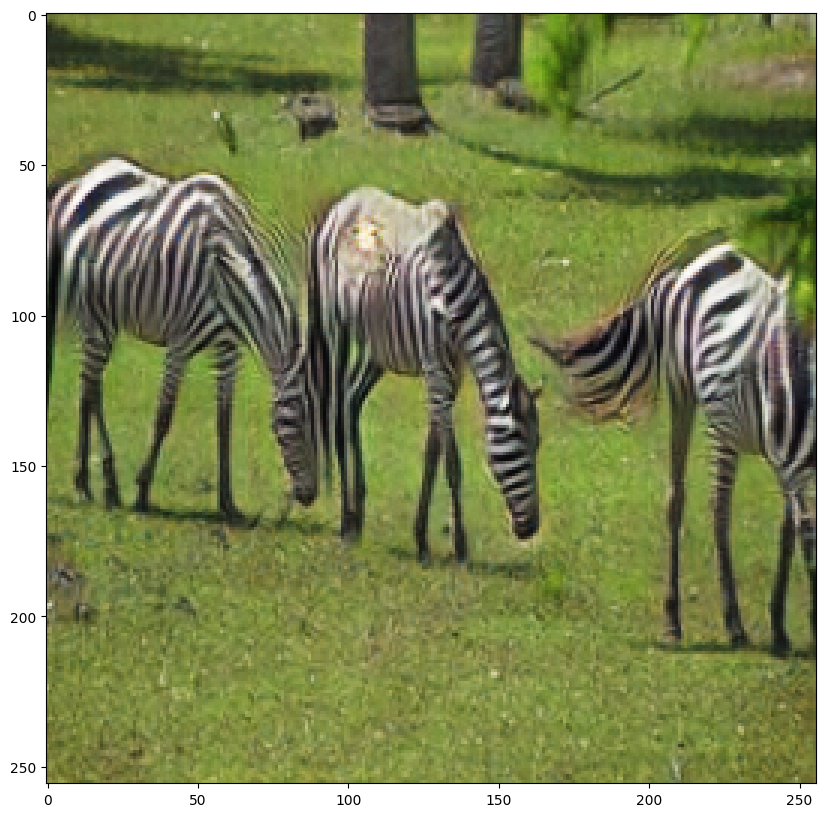

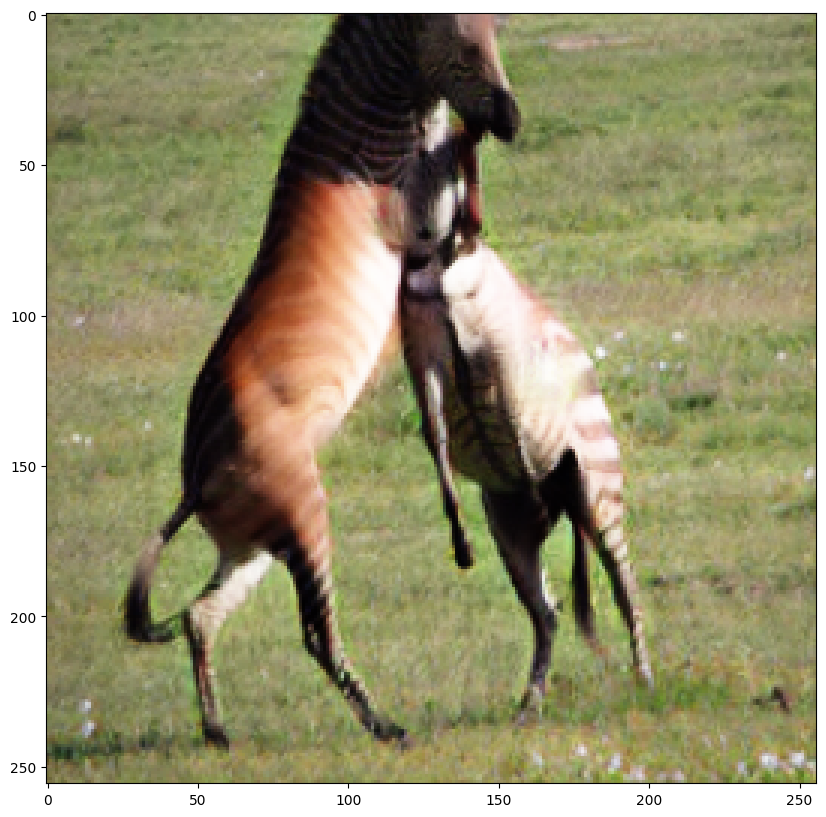

In [ ]:
def show_trans_image(image_tensor):
    image_transformed = (image_tensor + 1) / 2
    image_unflat = image_transformed.detach().cpu()
    image = image_unflat.permute(1, 2, 0).squeeze()
    image_flipped = np.fliplr(image) 
    plt.imshow(image)
    plt.show()

show_trans_image(trans_B)
show_trans_image(trans_A)

"""Dis entagnled Feautres needed"""

In [ ]:
torch.cuda.empty_cache()     # empty GPU memory cache

## OUTPUT

In [ ]:
img1 = image1
img2 = 'fake_zebra.png'

img3 = 'Screenshot from 2023-10-30 19-38-53.png'
img4 = 'Screenshot from 2023-10-30 19-38-44.png'

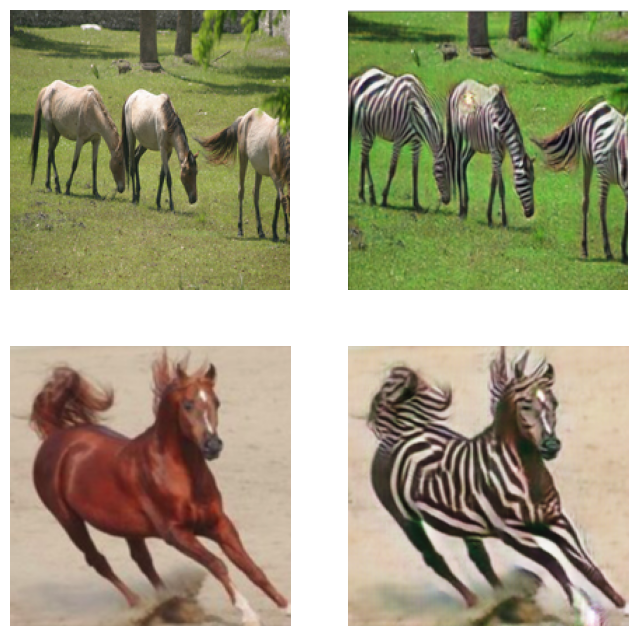

In [ ]:

# Open the images
img1 = Image.open('test_img_1.jpg')
img2 = Image.open('fake_zebra.png')
img3 = Image.open('Screenshot from 2023-10-30 19-38-53.png')
img4 = Image.open('Screenshot from 2023-10-30 19-38-44.png')

# Resize images to the same height (adjust width proportionally)
target_height = 200
aspect_ratio = img1.width / img1.height
new_width = int(target_height * aspect_ratio)

img1 = img1.resize((new_width, target_height))
img2 = img2.resize((new_width, target_height))
img3 = img3.resize((new_width, target_height))
img4 = img4.resize((new_width, target_height))

# Create a new figure
plt.figure(figsize=(8, 8))

# Plot the images
plt.subplot(2, 2, 1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img2)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img3)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(img4)
plt.axis('off')

# Save the arranged image
plt.savefig('arranged_images_matplotlib.png', bbox_inches='tight')

# Display the arranged image (optional)
plt.show()


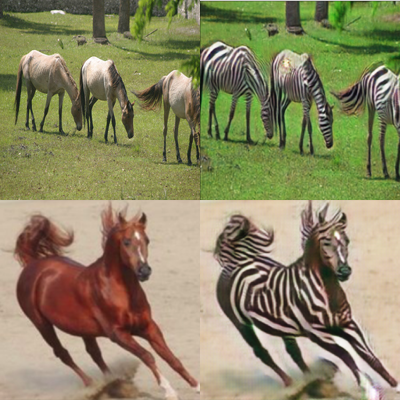

In [ ]:
Image.open('arranged_images.png')